In [1]:
# import napari
# viewer = napari.Viewer()

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import h5py
from anndata._io.specs import read_elem

from PIL import Image

import kornia.feature as KF
import torch
from skimage.transform import estimate_transform
from skimage.transform import SimilarityTransform

import numpy as np
from skimage.color import rgb2hsv
from skimage.filters import gaussian
from skimage.filters import threshold_otsu
from skimage.transform import rescale, resize
from scipy import ndimage
from skimage.transform import warp
from skimage.measure import ransac
from skimage.exposure import equalize_adapthist
from ultralytics import YOLO
from scipy.spatial.distance import cdist 
from skimage.color import gray2rgb
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from sklearn.neighbors import radius_neighbors_graph
from microfilm.microplot import microshow

Image.MAX_IMAGE_PIXELS = 933120000

This one works for H&E images. We specify a preprocessing routine to the image as a class (e.g., a valid python file with the class name)

This will go as arguments

In [3]:
sample_id_stitched_file = 'fc_sts_079_3'
sample_id = 'fc_sts_79_3'
adata_path = f"/data/rajewsky/home/dleonpe/projects/bruening_mpi_mm_hypothalamus_latest/notebooks/_misc/align_with_he/fc_sts_079_3_stitched_spots_nospace.h5ad"
stitched_image_he_or = np.array(Image.open(f"/data/rajewsky/home/dleonpe/projects/bruening_mpi_mm_hypothalamus_latest/data/1_images.bruening_mm_hypo_final_exp/stitched/{sample_id}/Image_Stitched_Composite.tif"))

RESCALE_FACTOR = 20
TISSUE_MASKING_GAUSSIAN_SIGMA = 5
SET_WHITE_BACKGROUND = True

THRESHOLD_COUNTS = 1
PSEUDOIMG_SIZE = 4000

Loading the image data, and preprocessing - **contains report for html file**

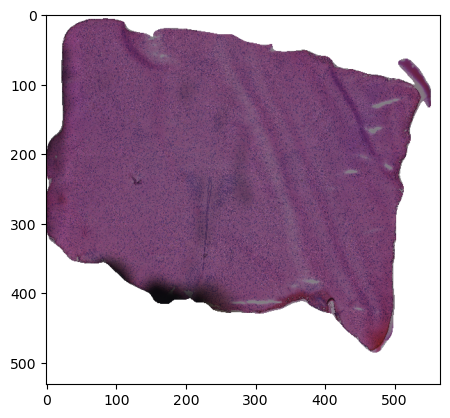

In [4]:
# Downscaling, specify with an argument
stitched_image_he = stitched_image_he_or[::RESCALE_FACTOR, ::RESCALE_FACTOR]
hsv_stitched_image_he = rgb2hsv(stitched_image_he)
s_stitched_image_he_gaussian = gaussian(hsv_stitched_image_he[..., 1], sigma=TISSUE_MASKING_GAUSSIAN_SIGMA)
thresh = threshold_otsu(s_stitched_image_he_gaussian)
s_stitched_image_he_gaussian_binary = s_stitched_image_he_gaussian > thresh
s_stitched_image_he_gaussian_binary = ndimage.binary_fill_holes(s_stitched_image_he_gaussian_binary).astype(int)

# REPORT:
plt.imshow(s_stitched_image_he_gaussian_binary)

# Removing background (setting to white)
stitched_image_he_masked = stitched_image_he * s_stitched_image_he_gaussian_binary[..., np.newaxis]
hsv_stitched_image_he_masked = hsv_stitched_image_he * s_stitched_image_he_gaussian_binary[..., np.newaxis]

if SET_WHITE_BACKGROUND:
    stitched_image_he_masked = np.where(stitched_image_he_masked == np.array([[0, 0, 0]]), np.array([[255, 255, 255]]), stitched_image_he_masked)
    hsv_stitched_image_he_masked = np.where(hsv_stitched_image_he_masked == np.array([[0, 0, 0]]), np.array([[1, 1, 1]]), hsv_stitched_image_he_masked)

# REPORT:
plt.imshow(stitched_image_he_masked)

Creating pseudoimage

(-0.5, 565.5, 530.5, -0.5)

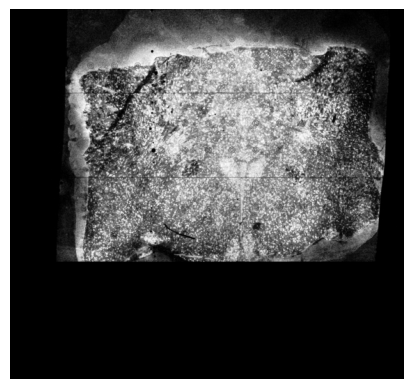

In [5]:
with h5py.File(adata_path) as f:
    adata_spatial = read_elem(f["obsm/spatial"])
    adata_counts = read_elem(f["obs/total_counts"])
    adata_tile = read_elem(f["obs/puck_id"])

# Apply coordinate transformation (zero-rescaling)
adata_spatial_thresholded = adata_spatial[adata_counts > 1]
offset_factor = adata_spatial_thresholded.min(axis=0)
adata_spatial_thresholded -= offset_factor

# Rescale the coordinates to have approximately PSEUDOIMG_SIZE
rescale_factor = adata_spatial_thresholded.max(axis=0).min()
adata_spatial_thresholded_rescaled = adata_spatial_thresholded / rescale_factor
adata_spatial_thresholded_rescaled *= PSEUDOIMG_SIZE
adata_spatial_thresholded_rescaled_int = adata_spatial_thresholded_rescaled.astype(int)

# Calculate the image limits, to preserve the aspect ratio, and not 'crop' the coordinates of the spatial dataset
dim_1, dim_2 = adata_spatial_thresholded_rescaled_int.max(axis=0)
dim_2_prop = dim_1/(stitched_image_he_masked.shape[0]/stitched_image_he_masked.shape[1])
dim_1_prop = dim_2/(stitched_image_he_masked.shape[1]/stitched_image_he_masked.shape[0])

if dim_2_prop < dim_2:
    dim_1 = int(dim_1_prop)+1
    dim_2 = int(dim_1_prop/(stitched_image_he_masked.shape[0]/stitched_image_he_masked.shape[1]))+1
elif dim_1_prop < dim_1:
    dim_2 = int(dim_2_prop)+1
    dim_1 = int(dim_2_prop/(stitched_image_he_masked.shape[1]/stitched_image_he_masked.shape[0]))+1

_sts_pseudoimage = np.zeros((dim_1+1, dim_2+1))
_sts_pseudoimage[adata_spatial_thresholded_rescaled_int[:, 0], adata_spatial_thresholded_rescaled_int[:, 1]] += 1
sts_pseudoimage = resize(_sts_pseudoimage, stitched_image_he_masked[..., 0].shape, anti_aliasing=True)

# calculate scaling ratio from the initially transformed points; use these points for applying the transform matrix (not integer)
rescaling_factor = sts_pseudoimage.shape[0]/_sts_pseudoimage.shape[0]
adata_spatial_thresholded_rescaled_resized = adata_spatial_thresholded_rescaled * rescaling_factor

# REPORT
plt.imshow(sts_pseudoimage, cmap='Greys_r')
plt.axis("off")

Run automatic feature matching

In [6]:
def find_matches(src, dst, pretrained='outdoor'):
    if type(src) is not list:
        raise TypeError("'src' must be a list of images")
    
    if type(dst) is not list:
        raise TypeError("'dst' must be a list of images")
    
    mkpts0 = np.array([[0, 0]])
    mkpts1 = np.array([[0, 0]])

    for _i_dst in dst:
        _dst_tensor = torch.tensor(_i_dst)[None, None]
        for _i_src in src:
            _src_tensor = torch.tensor(_i_src)[None, None]
            matcher = KF.LoFTR(pretrained=pretrained)

            input_dict = {
                "image0": _dst_tensor.float(),
                "image1": _src_tensor.float(),
            }

            with torch.inference_mode():
                correspondences = matcher(input_dict)

            mkpts0 = np.concatenate([correspondences["keypoints0"].cpu().numpy(), mkpts0])
            mkpts1 = np.concatenate([correspondences["keypoints1"].cpu().numpy(), mkpts1])

    return mkpts0, mkpts1

Find rough matches between the two modalities

In [7]:
mkpts0_all_flip = {}
mkpts1_all_flip = {}

for _flip_x in [1, -1]:
    for _flip_y in [1, -1]:
        src = [equalize_adapthist(im)[::_flip_x, ::_flip_y].copy() for im in hsv_stitched_image_he_masked.transpose(2, 0, 1)] + [equalize_adapthist(im)[::_flip_x, ::_flip_y].copy() for im in stitched_image_he_masked.transpose(2, 0, 1)]
        dst = [((-sts_pseudoimage)-((-sts_pseudoimage).min()))]

        mkpts0, mkpts1 = find_matches(src, dst)
        mkpts0_all_flip[f"[::{_flip_x},::{_flip_y}]"] = mkpts0
        mkpts1_all_flip[f"[::{_flip_x},::{_flip_y}]"] = mkpts1

/home/dleonpe/miniconda3/envs/napari-env/lib/python3.9/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting int64 to uint16 without scaling because max value 255 fits in uint16
  return _convert(image, np.uint16, force_copy)


Filter the matches using ransac

In [8]:
inliers_all_flip = {}

for _flip_x in [1, -1]:
    for _flip_y in [1, -1]:
        model_robust, inliers = ransac((mkpts0_all_flip[f"[::{_flip_x},::{_flip_y}]"], mkpts1_all_flip[f"[::{_flip_x},::{_flip_y}]"]),
                                    SimilarityTransform, min_samples=3,
                                    residual_threshold=2, max_trials=10000)
        inliers = (inliers > 0)
        inliers_all_flip[f"[::{_flip_x},::{_flip_y}]"] = inliers

In [9]:
_best_inlier = np.argmax([inliers.sum() for inliers in list(inliers_all_flip.values())])
inliers = inliers_all_flip[list(inliers_all_flip.keys())[_best_inlier]]
mkpts0 = mkpts0_all_flip[list(inliers_all_flip.keys())[_best_inlier]]
mkpts1 = mkpts1_all_flip[list(inliers_all_flip.keys())[_best_inlier]]

In [10]:
tform = estimate_transform('similarity', mkpts1[inliers], mkpts0[inliers])

**REPORT**

In [11]:
_flips = [[1, 1], [1, -1], [-1, 1], [-1, -1]]

In [12]:
_flip_x, _flip_y = _flips[_best_inlier]
src = [equalize_adapthist(im)[::_flip_x, ::_flip_y].copy() for im in hsv_stitched_image_he_masked.transpose(2, 0, 1)] + [equalize_adapthist(im)[::_flip_x, ::_flip_y].copy() for im in stitched_image_he_masked.transpose(2, 0, 1)]
dst = [((-sts_pseudoimage)-((-sts_pseudoimage).min()))]

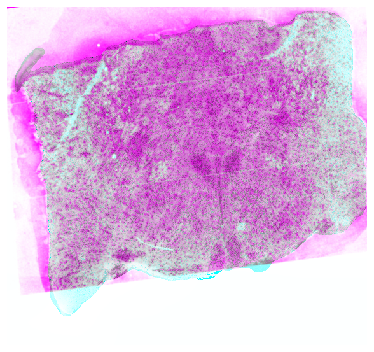

In [13]:
sts_modality_tformed = warp(dst[0], tform)
image_modality_tformed = src[0]
image = np.concatenate([image_modality_tformed[..., np.newaxis], sts_modality_tformed[..., np.newaxis]], axis=-1)

microim = microshow(
    images=image.transpose(2, 0, 1), fig_scaling=5,
    cmaps=['pure_magenta','pure_cyan'])

In [14]:
# Filter the keypoints with the inliers from RANSAC
in_mkpts0, in_mkpts1 = mkpts0[inliers.flatten()], mkpts1[inliers.flatten()]

# Estimate the transform
tform_points = estimate_transform('similarity', in_mkpts0, in_mkpts1)

# Apply the transform
adata_spatial_transform = np.dot(tform_points.params, np.concatenate([adata_spatial_thresholded_rescaled_resized[:, ::-1], np.ones((len(adata_spatial_thresholded_rescaled_resized), 1))], axis=1).T).T
rescaling_factor_he = stitched_image_he_masked.shape[0]/stitched_image_he_or.shape[0]
adata_spatial_thresholded_reconstruct = (adata_spatial_transform  / rescaling_factor_he)
adata_spatial_thresholded_reconstruct = adata_spatial_thresholded_reconstruct[(adata_spatial_thresholded_reconstruct[:, 0] >= 0) & \
                                                                              (adata_spatial_thresholded_reconstruct[:, 1] >= 0)   ]

In [15]:
with h5py.File(adata_path) as f:
    adata_spatial = read_elem(f["obsm/spatial"])
    adata_counts = read_elem(f["obs/total_counts"])

# Apply coordinate transformation (zero-rescaling)
adata_spatial_thresholded = adata_spatial[adata_counts > 0]
offset_factor = adata_spatial_thresholded.min(axis=0)
adata_spatial_thresholded -= offset_factor

# Rescale the coordinates to have approximately PSEUDOIMG_SIZE
rescale_factor = adata_spatial_thresholded.max(axis=0).min()
adata_spatial_thresholded_rescaled = adata_spatial_thresholded / rescale_factor
adata_spatial_thresholded_rescaled *= PSEUDOIMG_SIZE
adata_spatial_thresholded_rescaled_int = adata_spatial_thresholded_rescaled.astype(int)

# Calculate the image limits, to preserve the aspect ratio, and not 'crop' the coordinates of the spatial dataset
dim_1, dim_2 = adata_spatial_thresholded_rescaled_int.max(axis=0)
dim_2_prop = dim_1/(stitched_image_he_masked.shape[0]/stitched_image_he_masked.shape[1])
dim_1_prop = dim_2/(stitched_image_he_masked.shape[1]/stitched_image_he_masked.shape[0])

if dim_2_prop < dim_2:
    dim_1 = int(dim_1_prop)+1
    dim_2 = int(dim_1_prop/(stitched_image_he_masked.shape[0]/stitched_image_he_masked.shape[1]))+1
elif dim_1_prop < dim_1:
    dim_2 = int(dim_2_prop)+1
    dim_1 = int(dim_2_prop/(stitched_image_he_masked.shape[1]/stitched_image_he_masked.shape[0]))+1

_sts_pseudoimage = np.zeros((dim_1+1, dim_2+1))
_sts_pseudoimage[adata_spatial_thresholded_rescaled_int[:, 0], adata_spatial_thresholded_rescaled_int[:, 1]] += 1
sts_pseudoimage = resize(_sts_pseudoimage, stitched_image_he_masked[..., 0].shape, anti_aliasing=True)

# calculate scaling ratio from the initially transformed points; use these points for applying the transform matrix (not integer)
rescaling_factor = sts_pseudoimage.shape[0]/_sts_pseudoimage.shape[0]
adata_spatial_thresholded_rescaled_resized = adata_spatial_thresholded_rescaled * rescaling_factor

adata_spatial_transform = np.dot(tform_points.params, np.concatenate([adata_spatial_thresholded_rescaled_resized[:, ::-1], np.ones((len(adata_spatial_thresholded_rescaled_resized), 1))], axis=1).T).T
rescaling_factor_he = stitched_image_he_masked.shape[0]/stitched_image_he_or.shape[0]
_adata_spatial_thresholded_reconstruct = (adata_spatial_transform  / rescaling_factor_he)
adata_spatial_thresholded_reconstruct = _adata_spatial_thresholded_reconstruct[(_adata_spatial_thresholded_reconstruct[:, 0] >= 0) & \
                                                                              (_adata_spatial_thresholded_reconstruct[:, 1] >= 0)   ]

Detect fiducial markers in image modality

In [16]:
SQUARE_SIZE = 512
OFFSET = 256

In [17]:
def image_to_patches(image, corner_coord=[]):
    _img_shape = image.shape

    if len(corner_coord) == 0:
        for x in range(0, _img_shape[0]-SQUARE_SIZE, OFFSET):
            for y in range(0, _img_shape[1]-SQUARE_SIZE, OFFSET):
                corner_coord.append([x, y])

    subpatches = []
    for coord in corner_coord:
        subpatches.append(image[coord[0]:(coord[0]+SQUARE_SIZE), coord[1]:(coord[1]+SQUARE_SIZE)])

    return subpatches, np.array(corner_coord)

In [18]:
_flip_x, _flip_y = _flips[_best_inlier]
he_image_to_detect = stitched_image_he_or[::_flip_x, ::_flip_y]
subpatches, corner_coords = image_to_patches(he_image_to_detect)

In [19]:
model = YOLO('/data/rajewsky/home/dleonpe/projects/bruening_mpi_mm_hypothalamus_latest/notebooks/_misc/fiducial_detection/best.pt')
results = model(subpatches, batch=16, device='cpu')



    WARNING ⚠️ stream/video/webcam/dir predict source will accumulate results in RAM unless `stream=True` is passed,
    causing potential out-of-memory errors for large sources or long-running streams/videos.

    Example:
        results = model(source=..., stream=True)  # generator of Results objects
        for r in results:
            boxes = r.boxes  # Boxes object for bbox outputs
            masks = r.masks  # Masks object for segment masks outputs
            probs = r.probs  # Class probabilities for classification outputs

0: 512x512 (no detections), 1: 512x512 (no detections), 2: 512x512 (no detections), 3: 512x512 (no detections), 4: 512x512 (no detections), 5: 512x512 (no detections), 6: 512x512 (no detections), 7: 512x512 (no detections), 8: 512x512 (no detections), 9: 512x512 (no detections), 10: 512x512 (no detections), 11: 512x512 1 fiducial, 12: 512x512 1 fiducial, 13: 512x512 (no detections), 14: 512x512 1 fiducial, 15: 512x512 1 fiducial, 16: 512x512 1 fiducial,

In [20]:
def restitch_and_filter_matches(results, corner_coords, p=0.6):
    recentered_passed_matches = []
    filtered_matches = []

    for i in range(len(results)):
        _r = results[i].boxes.data.cpu().numpy()
        if (_r.shape[0] > 0):
            _r_filter = _r[_r[:, 4] > p]   
            for _r_f in _r_filter:
                if _r_f is not None:
                    _r_f[0] = _r_f[0] + corner_coords[i][1]
                    _r_f[1] = _r_f[1] + corner_coords[i][0]
                    _r_f[2] = _r_f[2] + corner_coords[i][1]
                    _r_f[3] = _r_f[3] + corner_coords[i][0]
                    recentered_passed_matches.append([i]+_r_f.tolist())

    recentered_passed_matches = np.array(recentered_passed_matches)[:, 1:5]
    for _passed in recentered_passed_matches:
        filtered_matches.append([((_passed[2]+_passed[0])/2), ((_passed[3]+_passed[1])/2)])

    return np.array(filtered_matches)

In [21]:
def cleanup_matches(matches, dist_threshold=300, low=0, high=1e9):
    clean_matches = []
    
    _matches = np.clip(matches, low, high).astype(int)
    
    for _match in matches:
        if (not clean_matches) or (cdist(_match[np.newaxis, :], np.array(clean_matches)).min() >= dist_threshold):
            clean_matches.append(_match)
    
    return np.array(clean_matches)

In [22]:
passed = restitch_and_filter_matches(results, corner_coords, p=0.6)
passed = np.clip(passed, 0, np.array(he_image_to_detect.shape)[:-1].max()).astype(int)
passed = cleanup_matches(passed, 10, 0, np.array(he_image_to_detect.shape)[:-1].max())

**REPORT**

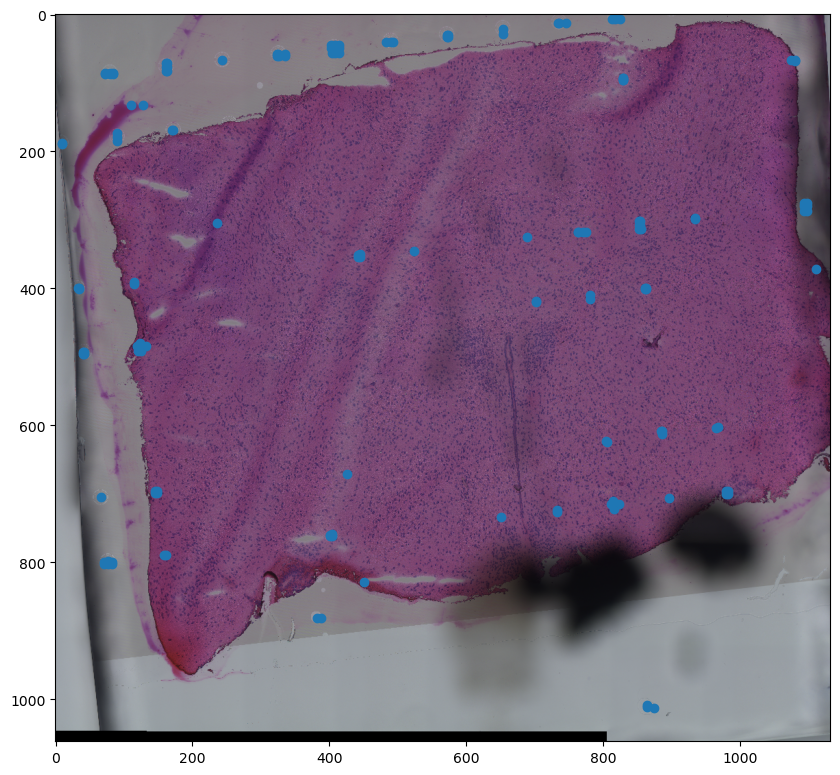

In [23]:
plt.figure(figsize=(10, 10))
plt.imshow(he_image_to_detect[::10,::10])
plt.scatter(passed[:, 0]*0.1, passed[:, 1]*0.1)

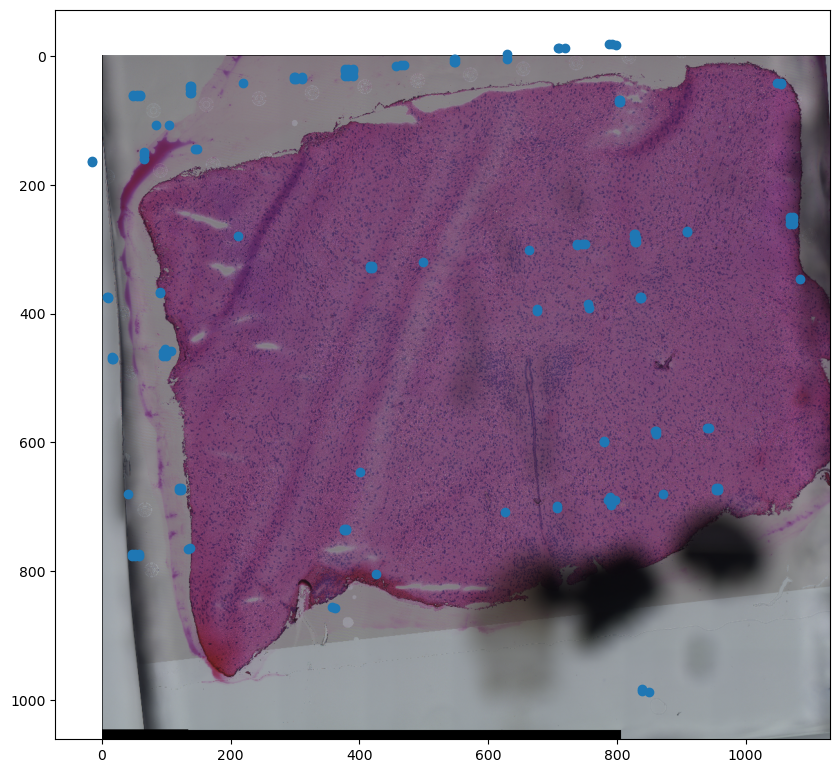

In [24]:
plt.figure(figsize=(10, 10))
plt.imshow(he_image_to_detect[::10,::10])
plt.scatter(passed[:, 0]*0.1-25, passed[:, 1]*0.1-25)

In [25]:
def cleanup_patches(patches, corner_coords):
    clean_patches = []
    clean_corner_coords = []

    for patch, coord in zip(patches, corner_coords):
        if patch.size > 0:
            clean_patches.append(patch)
            clean_corner_coords.append(coord)

    return clean_patches, np.array(clean_corner_coords)

In [26]:
subpatches_refine, _ = image_to_patches(he_image_to_detect, passed[:, ::-1]-256)
subpatches_refine, passed_refine = cleanup_patches(subpatches_refine, passed[:, ::-1]-256)
results_refine = model(subpatches_refine)
passed_refine = restitch_and_filter_matches(results_refine, passed_refine, p=0.5)
#passed_refine = np.clip(passed_refine, 0, np.array(he_image_to_detect.shape)[:-1].max()).astype(int)
#passed_refine = cleanup_matches(passed_refine, 0)


0: 512x512 1 fiducial, 1: 512x512 1 fiducial, 2: 512x512 1 fiducial, 3: 512x512 1 fiducial, 4: 512x512 1 fiducial, 5: 512x512 1 fiducial, 6: 512x512 1 fiducial, 7: 512x512 1 fiducial, 8: 512x512 1 fiducial, 9: 512x512 1 fiducial, 10: 512x512 1 fiducial, 11: 512x512 1 fiducial, 12: 512x512 1 fiducial, 13: 512x512 1 fiducial, 14: 512x512 1 fiducial, 15: 512x512 1 fiducial, 16: 512x512 1 fiducial, 17: 512x512 1 fiducial, 18: 512x512 1 fiducial, 19: 512x512 1 fiducial, 20: 512x512 1 fiducial, 21: 512x512 1 fiducial, 22: 512x512 1 fiducial, 23: 512x512 1 fiducial, 24: 512x512 1 fiducial, 25: 512x512 1 fiducial, 26: 512x512 1 fiducial, 27: 512x512 1 fiducial, 28: 512x512 1 fiducial, 29: 512x512 1 fiducial, 30: 512x512 1 fiducial, 31: 512x512 1 fiducial, 32: 512x512 1 fiducial, 33: 512x512 1 fiducial, 34: 512x512 1 fiducial, 35: 512x512 1 fiducial, 36: 512x512 1 fiducial, 37: 512x512 1 fiducial, 38: 512x512 1 fiducial, 39: 512x512 1 fiducial, 40: 512x512 1 fiducial, 41: 512x512 1 fiducial, 4

**REPORT**

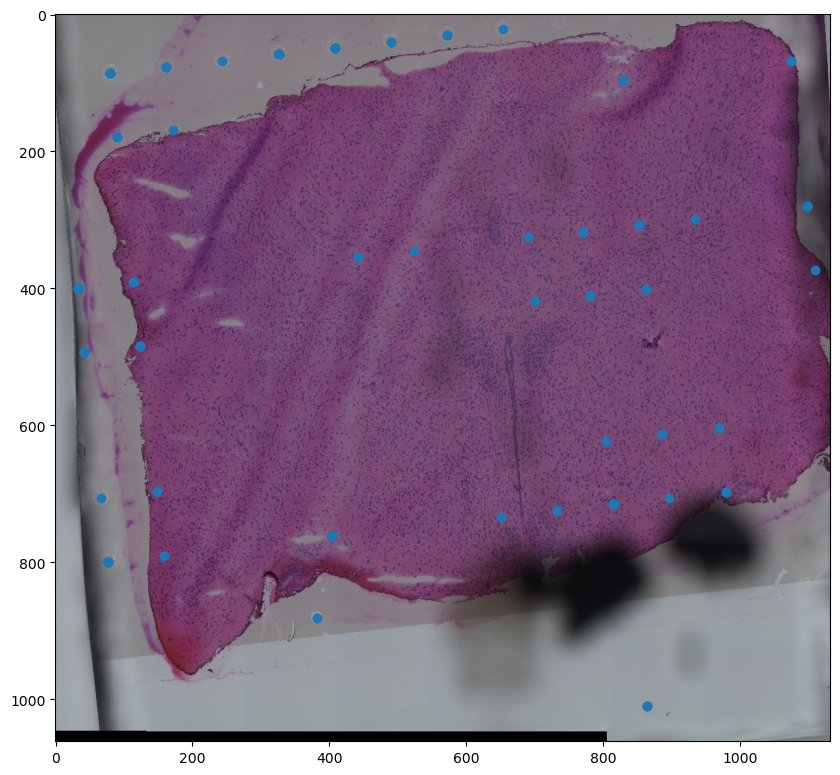

In [27]:
plt.figure(figsize=(10, 10))
plt.imshow(he_image_to_detect[::10,::10])
plt.scatter(passed_refine[:, 0]*0.1, passed_refine[:, 1]*0.1)

Run matching on the tile data (pseudoimage)

(-0.5, 5587.5, 4000.5, -0.5)

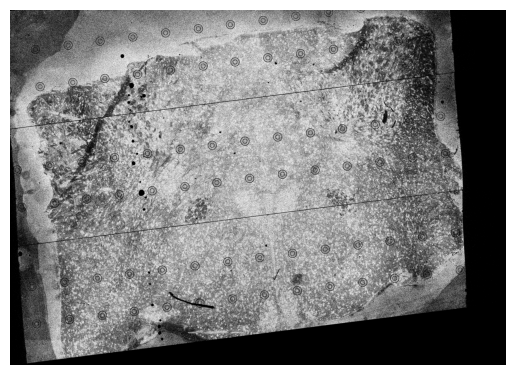

In [28]:
# Do not apply coordinate transformation
sts_coords_recenter = adata_spatial_thresholded_reconstruct.copy()[:, :-1][:, ::-1]
offset_factor = sts_coords_recenter.min(axis=0)
sts_coords_recenter -= offset_factor

# Rescale the coordinates to have approximately PSEUDOIMG_SIZE
rescale_factor = sts_coords_recenter.max(axis=0).min()
sts_coords_recenter_rescaled = sts_coords_recenter / rescale_factor
sts_coords_recenter_rescaled *= PSEUDOIMG_SIZE
sts_coords_recenter_rescaled = sts_coords_recenter_rescaled.astype(int)

dim_1, dim_2 = sts_coords_recenter_rescaled.max(axis=0) + 1

sts_pseudoimage = np.zeros((dim_1, dim_2))
sts_pseudoimage[sts_coords_recenter_rescaled[:, 0], sts_coords_recenter_rescaled[:, 1]] += 1
sts_pseudoimage = gray2rgb(sts_pseudoimage).astype(np.uint8)*255

# calculate scaling ratio from the initially transformed points; use these points for applying the transform matrix (not integer)
sts_coords_recenter_rescaled = sts_coords_recenter / rescale_factor
sts_coords_recenter_rescaled *= PSEUDOIMG_SIZE

plt.imshow(sts_pseudoimage, cmap='Greys_r')
plt.axis("off")

In [29]:
patches_tile, corner_coord_tile = image_to_patches(sts_pseudoimage, [])

In [30]:
model = YOLO('/data/rajewsky/home/dleonpe/projects/bruening_mpi_mm_hypothalamus_latest/notebooks/_misc/fiducial_detection/best_tile.pt')
results = model(patches_tile, device='cpu')


0: 512x512 1 fiducial, 1: 512x512 3 fiducials, 2: 512x512 4 fiducials, 3: 512x512 1 fiducial, 4: 512x512 2 fiducials, 5: 512x512 2 fiducials, 6: 512x512 1 fiducial, 7: 512x512 3 fiducials, 8: 512x512 2 fiducials, 9: 512x512 2 fiducials, 10: 512x512 2 fiducials, 11: 512x512 4 fiducials, 12: 512x512 4 fiducials, 13: 512x512 2 fiducials, 14: 512x512 6 fiducials, 15: 512x512 5 fiducials, 16: 512x512 2 fiducials, 17: 512x512 3 fiducials, 18: 512x512 (no detections), 19: 512x512 3 fiducials, 20: 512x512 1 fiducial, 21: 512x512 3 fiducials, 22: 512x512 2 fiducials, 23: 512x512 2 fiducials, 24: 512x512 5 fiducials, 25: 512x512 6 fiducials, 26: 512x512 3 fiducials, 27: 512x512 5 fiducials, 28: 512x512 3 fiducials, 29: 512x512 1 fiducial, 30: 512x512 2 fiducials, 31: 512x512 2 fiducials, 32: 512x512 1 fiducial, 33: 512x512 1 fiducial, 34: 512x512 3 fiducials, 35: 512x512 4 fiducials, 36: 512x512 4 fiducials, 37: 512x512 4 fiducials, 38: 512x512 2 fiducials, 39: 512x512 2 fiducials, 40: 512x512 

In [31]:
passed_tile = restitch_and_filter_matches(results, corner_coord_tile, p=0.6)
passed_tile = np.clip(passed_tile, 0, np.array(sts_pseudoimage.shape)[:-1].max()).astype(int)
passed_tile = cleanup_matches(passed_tile, 500, 0, np.array(sts_pseudoimage.shape)[:-1].max())

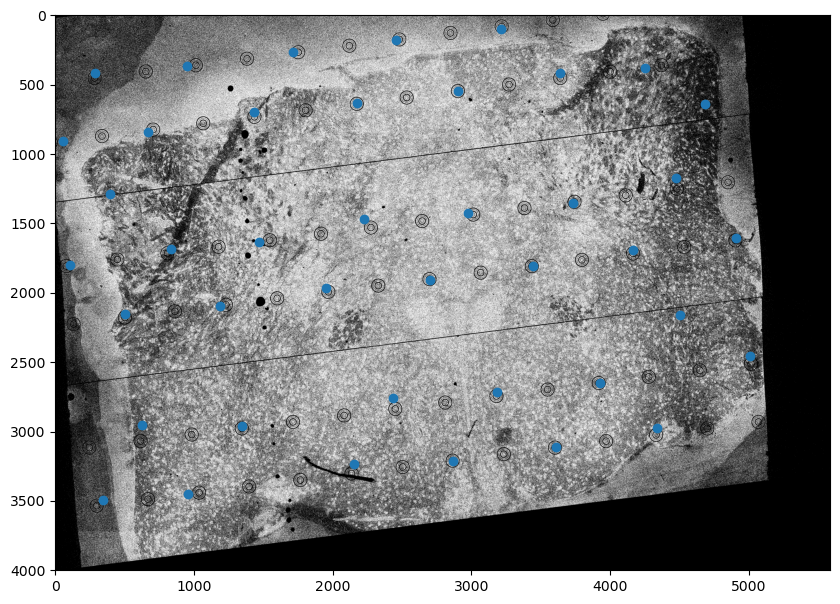

In [32]:
plt.figure(figsize=(10, 10))
plt.imshow(sts_pseudoimage, cmap='Greys_r')
plt.scatter(passed_tile[:, 0], passed_tile[:, 1])

In [33]:
subpatches_refine_tile, _ = image_to_patches(sts_pseudoimage, passed_tile[:, ::-1]-240)
subpatches_refine_tile, passed_tile_refine = cleanup_patches(subpatches_refine_tile, passed_tile[:, ::-1]-240)

results_refine_tile = model(subpatches_refine_tile)

passed_refine_tile = restitch_and_filter_matches(results_refine_tile, passed_tile_refine, p=0.8)
passed_refine_tile = np.clip(passed_refine_tile, 0, np.array(sts_pseudoimage.shape)[:-1].max()).astype(int)
passed_refine_tile = cleanup_matches(passed_refine_tile, 10)


0: 512x512 1 fiducial, 1: 512x512 1 fiducial, 2: 512x512 1 fiducial, 3: 512x512 1 fiducial, 4: 512x512 3 fiducials, 5: 512x512 1 fiducial, 6: 512x512 1 fiducial, 7: 512x512 1 fiducial, 8: 512x512 1 fiducial, 9: 512x512 2 fiducials, 10: 512x512 2 fiducials, 11: 512x512 2 fiducials, 12: 512x512 1 fiducial, 13: 512x512 1 fiducial, 14: 512x512 1 fiducial, 15: 512x512 2 fiducials, 16: 512x512 1 fiducial, 17: 512x512 1 fiducial, 18: 512x512 2 fiducials, 19: 512x512 2 fiducials, 20: 512x512 1 fiducial, 21: 512x512 1 fiducial, 22: 512x512 3 fiducials, 23: 512x512 2 fiducials, 24: 512x512 2 fiducials, 25: 512x512 3 fiducials, 26: 512x512 1 fiducial, 27: 512x512 1 fiducial, 28: 512x512 1 fiducial, 29: 512x512 1 fiducial, 30: 512x512 1 fiducial, 31: 512x512 2 fiducials, 32: 512x512 1 fiducial, 33: 512x512 1 fiducial, 34: 512x512 1 fiducial, 35: 512x512 1 fiducial, 36: 512x512 2 fiducials, 1464.0ms
Speed: 0.7ms preprocess, 39.6ms inference, 0.3ms postprocess per image at shape (1, 3, 512, 512)


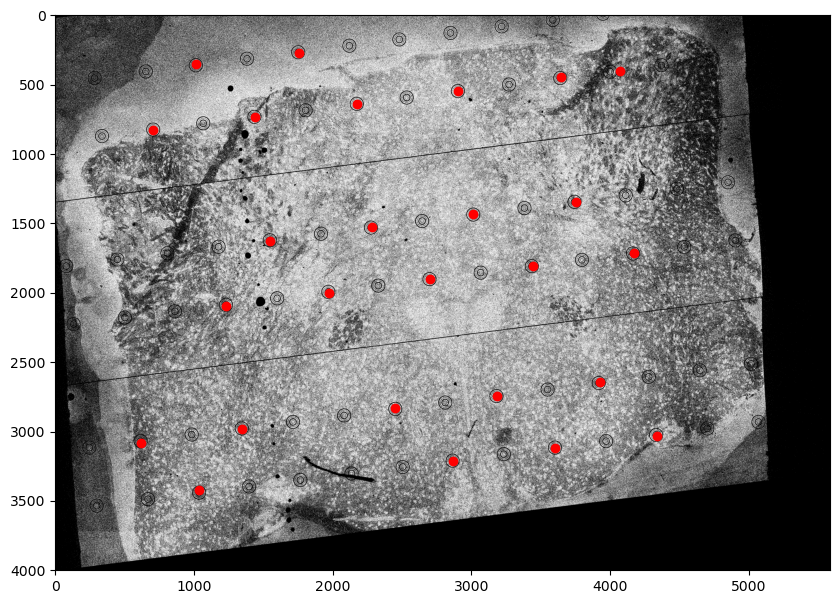

In [34]:
plt.figure(figsize=(10, 10))
plt.imshow(sts_pseudoimage, cmap='Greys_r')
plt.scatter(passed_refine_tile[:, 0], passed_refine_tile[:, 1], color='red')

In [35]:
# Readjust STS coordinates to image (HE)
passed_refine_tile_readjust = passed_refine_tile.copy()
passed_refine_tile_readjust = passed_refine_tile_readjust/PSEUDOIMG_SIZE
passed_refine_tile_readjust = passed_refine_tile_readjust*rescale_factor
passed_refine_tile_readjust = passed_refine_tile_readjust + offset_factor

sts_coords_recenter_rescaled_readjust = sts_coords_recenter_rescaled.copy()[:, ::-1]
sts_coords_recenter_rescaled_readjust = sts_coords_recenter_rescaled_readjust/PSEUDOIMG_SIZE
sts_coords_recenter_rescaled_readjust = sts_coords_recenter_rescaled_readjust*rescale_factor
sts_coords_recenter_rescaled_readjust = sts_coords_recenter_rescaled_readjust + offset_factor

(900.0, 0.0)

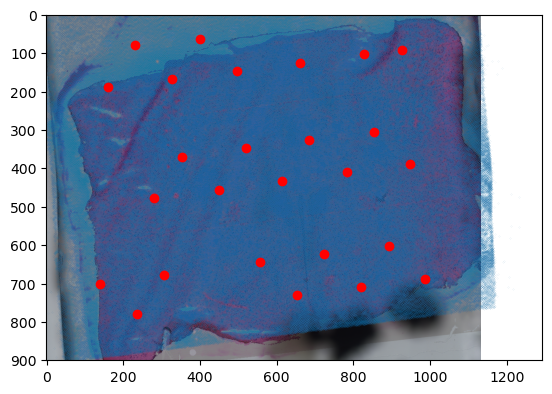

In [36]:
plt.imshow(he_image_to_detect[::10,::10])
plt.scatter(sts_coords_recenter_rescaled_readjust[::20, 0]*0.1, sts_coords_recenter_rescaled_readjust[::20, 1]*0.1, s=0.01, alpha=0.3)
plt.scatter(passed_refine_tile_readjust[:, 0]*0.1, passed_refine_tile_readjust[:, 1]*0.1, color='red')
plt.ylim(900, 0)

In [37]:
tile_codes = np.unique(adata_tile.codes)

In [38]:
outside_idx = (_adata_spatial_thresholded_reconstruct[:, 0] >= 0) & (_adata_spatial_thresholded_reconstruct[:, 1] >= 0)

In [39]:
tiles_coordinates = []

for tile_code in tile_codes:
    tiles_coordinates += [sts_coords_recenter_rescaled_readjust[adata_tile[(adata_counts > 0)].codes[(outside_idx)] == tile_code]]

In [40]:
def in_hull(p, hull):
    """
    Test if points in `p` are in `hull`

    `p` should be a `NxK` coordinates of `N` points in `K` dimensions
    `hull` is either a scipy.spatial.Delaunay object or the `MxK` array of the 
    coordinates of `M` points in `K`dimensions for which Delaunay triangulation
    will be computed
    """
    from scipy.spatial import Delaunay
    if not isinstance(hull,Delaunay):
        hull = Delaunay(hull)

    return hull.find_simplex(p)>=0

In [41]:
hulls = [ConvexHull(tile) for tile in tiles_coordinates]

points_in_tile = np.empty(len(passed_refine_tile_readjust), dtype='object')

for _i_p, _p in enumerate(passed_refine_tile_readjust):
    for i, tile_name in enumerate(tile_codes):
        _points_tile = tiles_coordinates[i][hulls[i].vertices]
        if in_hull(_p, _points_tile):
            points_in_tile[_i_p] = tile_name
            break

points_in_tile_imaging = np.empty(len(passed_refine), dtype='object')

for _i_p, _p in enumerate(passed_refine):
    for i, tile_name in enumerate(tile_codes):
        _points_tile = tiles_coordinates[i][hulls[i].vertices]
        if in_hull(_p, _points_tile):
            points_in_tile_imaging[_i_p] = tile_name
            break

(900.0, 0.0)

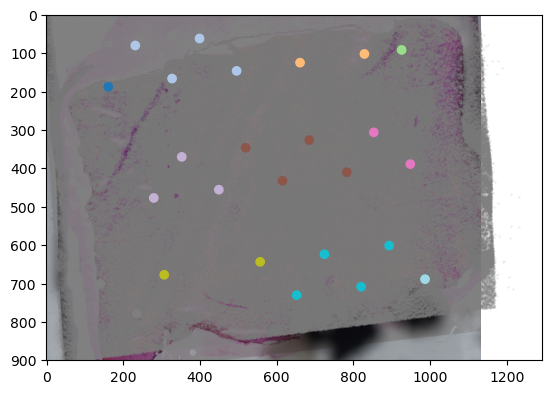

In [42]:
plt.imshow(he_image_to_detect[::10,::10])
plt.scatter(sts_coords_recenter_rescaled_readjust[::20, 0]*0.1, sts_coords_recenter_rescaled_readjust[::20, 1]*0.1, s=0.1, alpha=0.3, color='gray')
plt.scatter(passed_refine_tile_readjust[:, 0]*0.1, passed_refine_tile_readjust[:, 1]*0.1, c=points_in_tile, cmap='tab20')
plt.ylim(900, 0)

(900.0, 0.0)

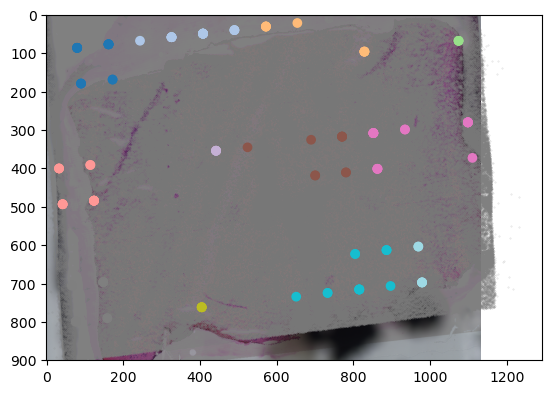

In [43]:
plt.imshow(he_image_to_detect[::10,::10])
plt.scatter(sts_coords_recenter_rescaled_readjust[::20, 0]*0.1, sts_coords_recenter_rescaled_readjust[::20, 1]*0.1, s=0.1, alpha=0.3, color='gray')
plt.scatter(passed_refine[:, 0]*0.1, passed_refine[:, 1]*0.1, c=points_in_tile_imaging, cmap='tab20')
plt.ylim(900, 0)

In [44]:
# # we can plot in napari to check that, indeed, just offsetting the tiles will align the modalities

# # import napari
# # viewer = napari.Viewer()

# image_he = viewer.add_image(he_image_to_detect)

# # points = viewer.add_points(
# #         tiles_coordinates[5][:, ::-1],
# #         size=10,
# #         opacity=0.2
# # )

# points = viewer.add_points(
#         passed_refine[:, ::-1],
#         size=100,
#         opacity=0.2,
#         face_color='red'
# )

# points = viewer.add_points(
#         passed_refine_tile_readjust[:, ::-1],
#         size=100,
#         opacity=0.2,
#         face_color='blue'
# )

In [45]:
# process per tile
DISTANCE_THRESHOLD = 200
tile_offsets = np.zeros((len(tile_codes), 2))

for i, tile_name in enumerate(tile_codes):
    _img_modality_fiducial = passed_refine[points_in_tile_imaging == tile_name]
    _sts_modality_fiducial = passed_refine_tile_readjust[points_in_tile == tile_name]

    _points_pairwise_distances = []
    for _s_f_i in range(len(_sts_modality_fiducial)):
        _pairwise_distances = np.linalg.norm(_img_modality_fiducial - _sts_modality_fiducial[_s_f_i:(_s_f_i+1)], axis=1)
        _pairwise_distances_idx = np.where(_pairwise_distances <= DISTANCE_THRESHOLD)
        if len(_pairwise_distances_idx[0]) == 0:
            continue

        _pairwise_distances_mean = np.mean(_img_modality_fiducial[_pairwise_distances_idx] - _sts_modality_fiducial[_s_f_i:(_s_f_i+1)], axis=0)
        _points_pairwise_distances += [_pairwise_distances_mean]

    _points_pairwise_distances = np.mean(_points_pairwise_distances, axis=0)
    tile_offsets[i] = _points_pairwise_distances

tile_offsets = np.nan_to_num(tile_offsets, nan=0)
    

/home/dleonpe/miniconda3/envs/napari-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dleonpe/miniconda3/envs/napari-env/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [46]:
tiles_coordinates_offsets = []

for tile_code in tile_codes:
    tiles_coordinates_offsets += [tiles_coordinates[tile_code] + tile_offsets[tile_code]]

In [47]:
points = viewer.add_points(
        tiles_coordinates_offsets[8][:, ::-1],
        size=11,
        opacity=0.2
)

NameError: name 'viewer' is not defined

Find a similarity transform for each of the tiles, transform the coordinates
This is only valid when various fiducial markers are available

Or, apply fine alignment per tile onto the stitched image -> use feature matching, then evaluate using the fiducial marks

In [ ]:
RESCALE_FACTOR = 5

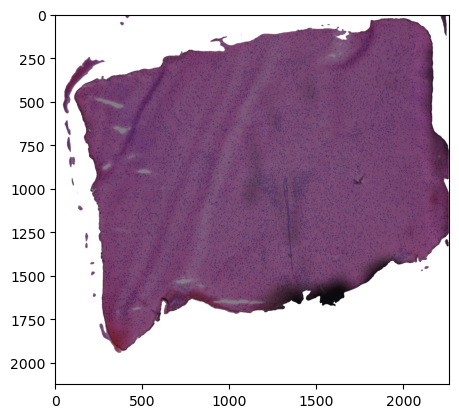

In [ ]:
_flip_x, _flip_y = _flips[_best_inlier]

# Downscaling, specify with an argument
stitched_image_he = stitched_image_he_or[::RESCALE_FACTOR, ::RESCALE_FACTOR]
stitched_image_he = stitched_image_he[::_flip_x, ::_flip_y]
hsv_stitched_image_he = rgb2hsv(stitched_image_he)
s_stitched_image_he_gaussian = gaussian(hsv_stitched_image_he[..., 1], sigma=TISSUE_MASKING_GAUSSIAN_SIGMA)
thresh = threshold_otsu(s_stitched_image_he_gaussian)
s_stitched_image_he_gaussian_binary = s_stitched_image_he_gaussian > thresh
s_stitched_image_he_gaussian_binary = ndimage.binary_fill_holes(s_stitched_image_he_gaussian_binary).astype(int)

# REPORT:
plt.imshow(s_stitched_image_he_gaussian_binary)

# Removing background (setting to white)
stitched_image_he_masked = stitched_image_he * s_stitched_image_he_gaussian_binary[..., np.newaxis]
hsv_stitched_image_he_masked = hsv_stitched_image_he * s_stitched_image_he_gaussian_binary[..., np.newaxis]

if SET_WHITE_BACKGROUND:
    stitched_image_he_masked = np.where(stitched_image_he_masked == np.array([[0, 0, 0]]), np.array([[255, 255, 255]]), stitched_image_he_masked)
    hsv_stitched_image_he_masked = np.where(hsv_stitched_image_he_masked == np.array([[0, 0, 0]]), np.array([[1, 1, 1]]), hsv_stitched_image_he_masked)

# REPORT:
plt.imshow(stitched_image_he_masked)

In [ ]:
sts_coords_recenter_rescaled_readjust = sts_coords_recenter_rescaled_readjust[np.where((sts_coords_recenter_rescaled_readjust[:, 0] > 0) &
                                                 (sts_coords_recenter_rescaled_readjust[:, 0] < stitched_image_he_or.shape[1]) &
                                                 (sts_coords_recenter_rescaled_readjust[:, 1] > 0) &
                                                 (sts_coords_recenter_rescaled_readjust[:, 1] < stitched_image_he_or.shape[0]))]

In [ ]:
# Do not apply coordinate transformation
PSEUDOIMG_SIZE = 6000
_sts_coords_recenter = sts_coords_recenter_rescaled_readjust.copy()[:, ::-1]
sts_coords_recenter = tiles_coordinates[8].copy()[:, ::-1]
# Remove coordinates outside of the image (we cannot assign these spatially, because there is no image data available)
sts_coords_recenter = sts_coords_recenter[np.where((sts_coords_recenter[:, 0] > 0) &
                                                 (sts_coords_recenter[:, 0] < stitched_image_he_or.shape[0]) &
                                                 (sts_coords_recenter[:, 1] > 0) &
                                                 (sts_coords_recenter[:, 1] < stitched_image_he_or.shape[1]))]


# Rescale the coordinates to have approximately PSEUDOIMG_SIZE
rescale_factor = _sts_coords_recenter.max(axis=0).min()
sts_coords_recenter_rescaled = sts_coords_recenter / rescale_factor
sts_coords_recenter_rescaled *= PSEUDOIMG_SIZE
sts_coords_recenter_rescaled_int = sts_coords_recenter_rescaled.astype(int)

_sts_coords_recenter_rescaled = _sts_coords_recenter / rescale_factor
_sts_coords_recenter_rescaled *= PSEUDOIMG_SIZE
_sts_coords_recenter_rescaled_int = _sts_coords_recenter_rescaled.astype(int)

# Calculate the image limits, to preserve the aspect ratio, and not 'crop' the coordinates of the spatial dataset
dim_1, dim_2 = _sts_coords_recenter_rescaled_int.max(axis=0)
dim_2_prop = dim_1/(stitched_image_he_masked.shape[0]/stitched_image_he_masked.shape[1])
dim_1_prop = dim_2/(stitched_image_he_masked.shape[1]/stitched_image_he_masked.shape[0])

if dim_2_prop < dim_2:
    dim_1 = int(dim_1_prop)+1
    dim_2 = int(dim_1_prop/(stitched_image_he_masked.shape[0]/stitched_image_he_masked.shape[1]))+1
elif dim_1_prop < dim_1:
    dim_2 = int(dim_2_prop)+1
    dim_1 = int(dim_2_prop/(stitched_image_he_masked.shape[1]/stitched_image_he_masked.shape[0]))+1

_sts_pseudoimage = np.zeros((dim_1+1, dim_2+1))
_sts_pseudoimage[sts_coords_recenter_rescaled_int[:, 0], sts_coords_recenter_rescaled_int[:, 1]] += 1
sts_pseudoimage = resize(_sts_pseudoimage, stitched_image_he_masked[..., 0].shape, anti_aliasing=True)

# calculate scaling ratio from the initially transformed points; use these points for applying the transform matrix (not integer)
rescaling_factor = sts_pseudoimage.shape[0]/_sts_pseudoimage.shape[0]
sts_coords_recenter_rescaled_resized = sts_coords_recenter_rescaled * rescaling_factor

In [ ]:
min_lim, max_lim = sts_coords_recenter_rescaled_resized.min(axis=0).astype(int), sts_coords_recenter_rescaled_resized.max(axis=0).astype(int)
x_min, y_min = min_lim
x_max, y_max = max_lim

(-0.5, 2263.5, 2123.5, -0.5)

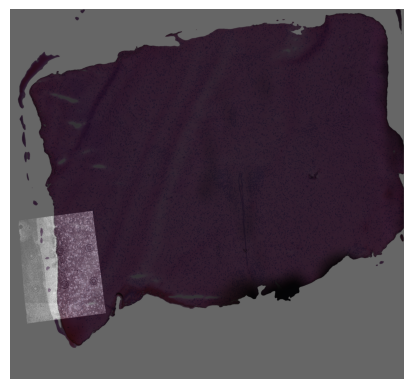

In [ ]:
# REPORT
plt.imshow(stitched_image_he_masked, cmap='Greys_r', alpha=1)
plt.imshow(sts_pseudoimage, cmap='Greys_r', alpha=0.6)
plt.axis("off")

In [ ]:
stitched_image_he_crop = stitched_image_he[x_min:x_max, y_min:y_max]
hsv_stitched_image_he_crop = hsv_stitched_image_he[x_min:x_max, y_min:y_max]
sts_pseudoimage_crop = sts_pseudoimage[x_min:x_max, y_min:y_max]

src = [gaussian(equalize_adapthist(im).copy(), 2) for im in hsv_stitched_image_he_crop.transpose(2, 0, 1)] + [gaussian(equalize_adapthist(im).copy(), 2) for im in stitched_image_he_crop.transpose(2, 0, 1)]
dst = [gaussian((-sts_pseudoimage_crop)-((-sts_pseudoimage_crop).min()), 2)]

mkpts0_tile, mkpts1_tile = find_matches(src, dst)

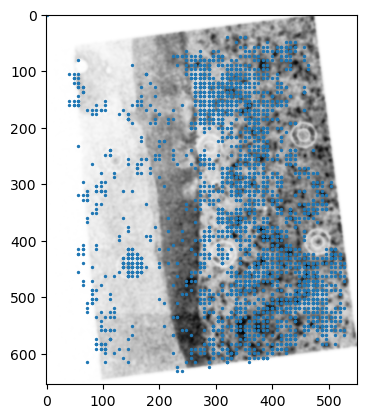

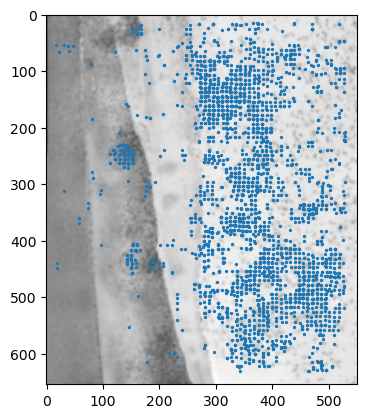

In [ ]:
plt.imshow(dst[0], cmap='Greys_r')
plt.scatter(mkpts0_tile[:, 0], mkpts0_tile[:, 1], s=2)
plt.show()

plt.imshow(src[0], cmap='Greys_r')
plt.scatter(mkpts1_tile[:, 0], mkpts1_tile[:, 1], s=2)

In [ ]:
RANSAC_REFINE_MIN_SAMPLES = 10
RANSAC_REFINE_RESIDUAL_THRESHOLD = 2
RANSAC_REFINE_MAX_TRIALS = 10000

In [ ]:
model_robust, inliers = ransac((mkpts0_tile, mkpts1_tile),
                            SimilarityTransform, min_samples=RANSAC_REFINE_MIN_SAMPLES,
                            residual_threshold=RANSAC_REFINE_RESIDUAL_THRESHOLD, max_trials=RANSAC_REFINE_MAX_TRIALS)
inliers = (inliers > 0)
tform = estimate_transform('similarity', mkpts1_tile[inliers], mkpts0_tile[inliers])
len(inliers)

3196

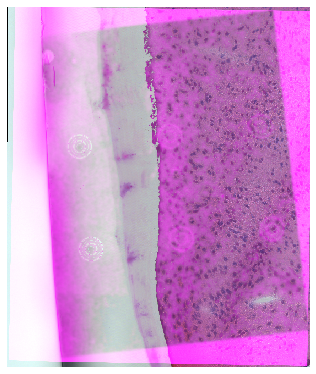

In [ ]:
# REPORT

sts_modality_tformed = warp(dst[0], tform)
image_modality_tformed = src[0]
image = np.concatenate([stitched_image_he[x_min:x_max, y_min:y_max], sts_modality_tformed[..., np.newaxis]], axis=-1)

microim = microshow(
    images=image.transpose(2, 0, 1), fig_scaling=5, #limits=[[0, 255], [0, 255], [0, 255], [0.5, 1.1]],
    cmaps=['pure_red', 'pure_green', 'pure_blue','pure_magenta'])

(400.0, 600.0)

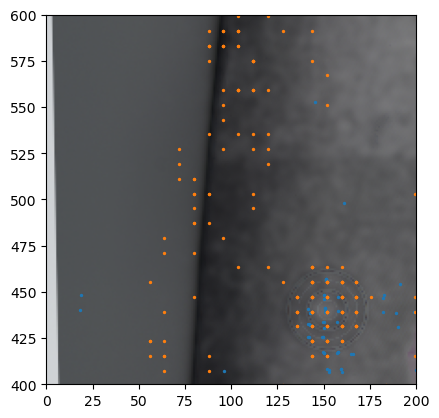

In [ ]:
plt.imshow(sts_modality_tformed, cmap='Greys')
plt.imshow(stitched_image_he[x_min:x_max, y_min:y_max], cmap='Greys_r', alpha=0.5)

plt.scatter(mkpts1_tile[:, 0], mkpts1_tile[:, 1], s=2)
plt.scatter(mkpts0_tile[:, 0], mkpts0_tile[:, 1], s=2)
plt.xlim(0, 200)
plt.ylim(400, 600)

(400.0, 600.0)

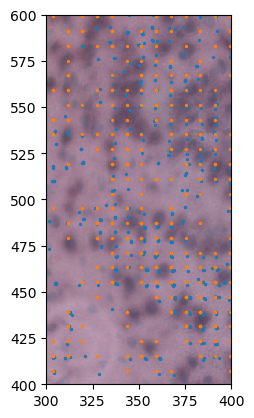

In [ ]:
plt.imshow(sts_modality_tformed, cmap='Greys_r')
plt.imshow(stitched_image_he[x_min:x_max, y_min:y_max], cmap='Greys_r', alpha=0.5)

plt.scatter(mkpts1_tile[:, 0], mkpts1_tile[:, 1], s=2)
plt.scatter(mkpts0_tile[:, 0], mkpts0_tile[:, 1], s=2)
plt.xlim(300, 400)
plt.ylim(400, 600)

Retransform the coordinates of the individual tiles back to the original HE dimensions

In [ ]:
dst[0].shape

(655, 550)

In [ ]:
src[0].shape

(655, 550)

In [ ]:
sts_coords_recenter_rescaled_resized_recenter = sts_coords_recenter_rescaled_resized - np.array([[x_min, y_min]])
#sts_coords_recenter_rescaled_resized_recenter = sts_coords_recenter_rescaled_resized.copy()


# Filter the keypoints with the inliers from RANSAC
in_mkpts0, in_mkpts1 = mkpts0_tile[inliers.flatten()], mkpts1_tile[inliers.flatten()]

# Estimate the transform
tform_points = estimate_transform('similarity', in_mkpts0, in_mkpts1)

# Apply the transform
adata_spatial_transform = np.dot(tform_points.params, np.concatenate([sts_coords_recenter_rescaled_resized_recenter, np.ones((len(sts_coords_recenter_rescaled_resized_recenter), 1))], axis=1).T).T
rescaling_factor_he = stitched_image_he_masked.shape[0]/stitched_image_he_or.shape[0]
adata_spatial_transform = (adata_spatial_transform[:, :-1] + np.array([[x_min, y_min]]))[:, ::-1]
adata_spatial_thresholded_reconstruct = (adata_spatial_transform  / rescaling_factor_he)
adata_spatial_thresholded_reconstruct = adata_spatial_thresholded_reconstruct[(adata_spatial_thresholded_reconstruct[:, 0] >= 0) & \
                                                                              (adata_spatial_thresholded_reconstruct[:, 1] >= 0)   ]


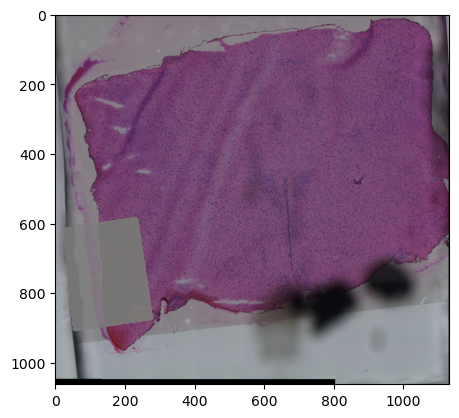

In [ ]:
plt.imshow(stitched_image_he_or[::10, ::10][::1, ::-1])
plt.scatter(adata_spatial_thresholded_reconstruct[:, 0]*0.1, adata_spatial_thresholded_reconstruct[:, 1]*0.1, s=0.01, alpha=0.6, color='gray')
plt.gca().set_aspect("equal")